# The Transformation and Accept/Reject (aka. Von Neumann) methods 

### Authors: 
- Troels C. Petersen (Niels Bohr Institute)

### Date:    
- 31-12-2019 (latest update)
***

Python notebook with exercise on how to generate random numbers following a specific PDF using uniformly distributed random numbers, in this case a third degree polynomial: $f(x) = x^3$, in the interval $[0, C]$ where $C$ is a number that ensures that the function if properly normalized.

Both the Accept-Reject (Von Neumann) and transformation method should be considered for the problem:
- Transformation method (if function can be integrated and then inverted).
- Accept-Reject (or Hit & Miss) method (by Ulam Stanislav and John Von Neumann).

For more information see:
- G. Cowan: Chapter 3
- P. R. Bevington: page 81-84
- __[40. Monte Carlo Techniques PDG](http://pdg.lbl.gov/2018/reviews/rpp2018-rev-monte-carlo-techniques.pdf)__

***

First we import the needed modules:

In [1]:
import numpy as np                                     # Matlab like syntax for linear algebra and functions
import matplotlib.pyplot as plt                        # Plots and figures like you know them from Matlab
import seaborn as sns                                  # Make the plots nicer to look at
from iminuit import Minuit                             # The actual fitting tool, better than scipy's
import sys                                             # Modules to see files and folders in directories
from scipy import stats

Load external functions:

In [2]:
sys.path.append('../../../External_Functions')
from ExternalFunctions import Chi2Regression, BinnedLH, UnbinnedLH
from ExternalFunctions import nice_string_output, add_text_to_ax    # Useful functions to print fit results on figure

plt.rcParams['font.size'] = 18     # Set some basic plotting parameters

set the parameters of the program:

In [3]:
r = np.random
r.seed(42)

save_plots = False  
N = 10000      # Number of random points used 

In [4]:
# f(x):
def fx_x3(x) :
    return x**3

In [5]:
# Transformation method:
x_transformation = (4*r.uniform(size=N))**0.25

In [6]:
# Accept/Reject method:
x_accepted = np.zeros(N)
xmin, xmax, ymax = 0.0, np.sqrt(2.0), np.sqrt(2.0)**3
Ntry = 0

for i in range(N):
    while True:
        Ntry += 1                    # Count the number of tries, to get efficiency/integral
        x = r.uniform(xmin, xmax)    # Range that f(x) is defined/wanted in
        y = r.uniform(0, ymax)       # Upper bound of the function
        if (y < fx_x3(x)) :
            break
    x_accepted[i] = x

The Accept/Reject method is not $100\%$ efficient, meaning that to generate $N$ random points according to $f(x)$ we have to loop $M > N$ times. The efficiency is then defined as $\epsilon = N / M = $ `eff`:

In [7]:
# Calculation of efficiency:
eff       = N / Ntry                        
eff_error = np.sqrt(eff * (1-eff) / Ntry) 

# Integral of function over range:
integral       = eff       * (xmax-xmin) * ymax 
integral_error = eff_error * (xmax-xmin) * ymax  

print(f"\n\nIntegral of f(x) = x^3, x in [0, sqrt(2)] is:              {integral:5.4f} +- {integral_error:5.4f}")
print(f"The efficiency of the Accept/Reject method used here is:   {eff:5.2%} +- {eff_error:5.2%}")
# The integral can be compared to the known value, namely unit, as it was normalised!



Integral of f(x) = x^3, x in [0, sqrt(2)] is:              1.0055 +- 0.0087
The efficiency of the Accept/Reject method used here is:   25.14% +- 0.22%


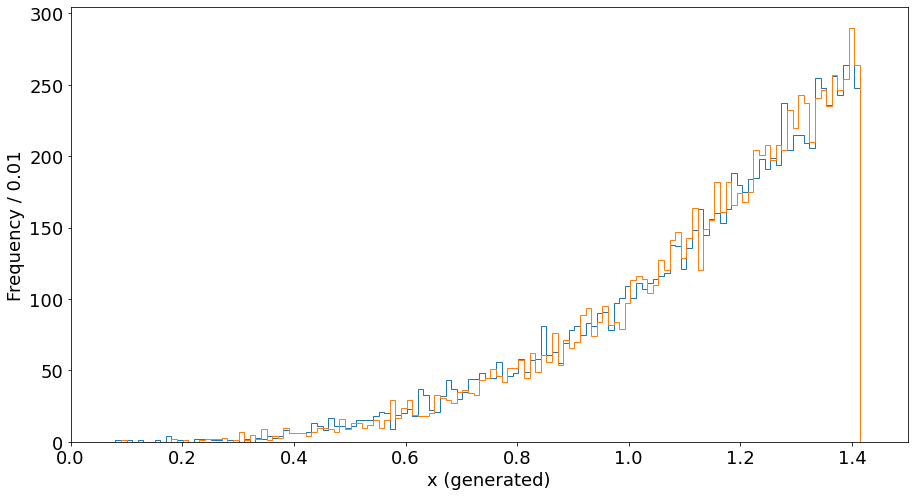

In [8]:
Nbins = 141
xmin, xmax = 0.0, np.sqrt(2)
binwidth = (xmax - xmin) / Nbins

fig, ax = plt.subplots(figsize=(15, 8))
ax.hist(x_transformation, bins=Nbins, range=(xmin, xmax), histtype='step', label='x (transformation)' )
ax.hist(x_accepted, bins=Nbins, range=(xmin, xmax), histtype='step', label='x (accept/reject)' )
ax.set(xlabel="x (generated)", ylabel="Frequency / 0.01", xlim=(xmin, 1.5));   # Note upper limit set a bit above!

### Fitting the distribution (cross check)

Note that one could also simply draw the expected distribution, and - if there were only few low statistics bins - calculate the ChiSquare to check the match. Alternatively, one could do a Kolmogorov-Smirnoff (KS) test between the function and the data.

In [9]:
# Note that this polynomial is NOT normalised!
# The "N" put outside is simply to minimize the (significant) correlations between the fit parameters.
def pol3_pdf(x, N, c0, c1, c2, c3):
    return N * (c0 + c1*x + c2*x*x + c3*x*x*x)

In [10]:
fit_object = UnbinnedLH(pol3_pdf, x_transformation, extended=True)
minuit = Minuit(fit_object, print_level=0, pedantic=False, N=1000, c0=0.0, c1=0.0, c2=0.0, c3=1.0)
minuit.migrad();
if (not minuit.fmin.is_valid) :                                   # Check if the fit converged!
    print("  WARNING: The unbinned likelihood fit DID NOT converge!!!")

In [11]:
minuit_output = [minuit.fmin, minuit.params]       # Save the output parameters in case needed
for name in minuit.parameters:
    print("  Unbinned LLH Fit result: {0} = {1:.5f} +/- {2:.5f}".format(name, minuit.values[name], minuit.errors[name]))

  Unbinned LLH Fit result: N = 2732.89871 +/- 333.34184
  Unbinned LLH Fit result: c0 = 0.09026 +/- 0.01361
  Unbinned LLH Fit result: c1 = -0.74631 +/- 0.09100
  Unbinned LLH Fit result: c2 = 1.57333 +/- 0.22932
  Unbinned LLH Fit result: c3 = 2.80076 +/- 0.40748


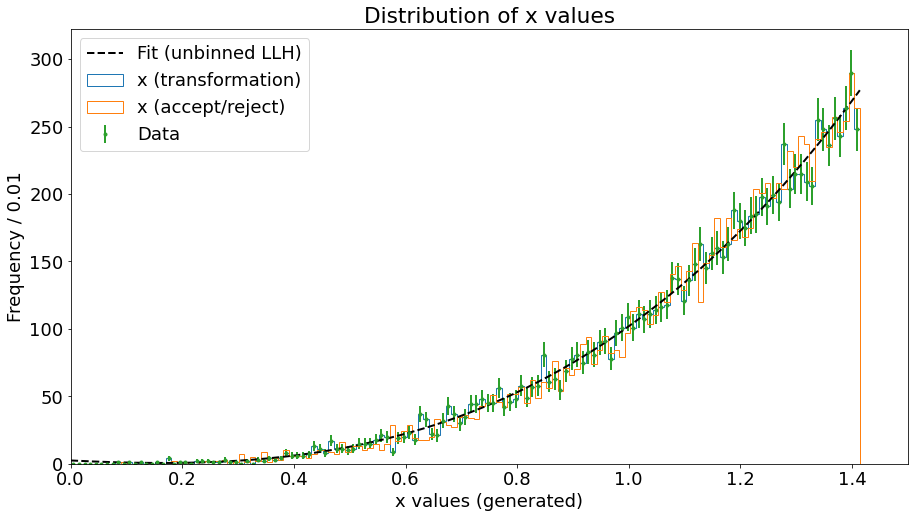

In [12]:
#fig2, ax2 = plt.subplots(figsize=(15, 6))
y, bin_edges = np.histogram(x_transformation, bins=Nbins, range=(xmin, xmax))
x = 0.5*(bin_edges[1:] + bin_edges[:-1])
sy = np.sqrt(y)      # This is the standard for histograms - bin entries are Poisson distributed!
hist_data = ax.errorbar(x, y, sy, fmt='.', linewidth=2, label="Data")
ax.set(xlabel="x values (generated)", ylabel = "Frequency / 0.01", title = "Distribution of x values")

# Plot fit result on top of histograms:
x_ulfit = np.linspace(xmin, xmax, 1000)                                    # Create the x-axis for the plot of the fitted function
y_ulfit = binwidth * pol3_pdf(x_ulfit, *minuit.args)
ax.plot(x_ulfit, y_ulfit, '--', color='black', linewidth=2, label='Fit (unbinned LLH)')
ax.legend()

if save_plots: 
    fig.savefig("DistXgenerated.pdf")
fig

### Now change the interval from [0, C] to [1, C]

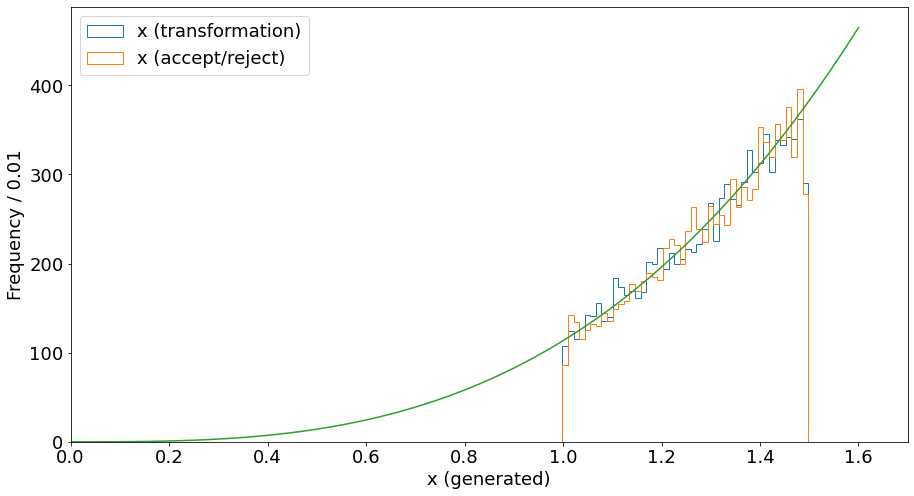

In [13]:
# Transformation method:
x_transformation2 = (4*r.uniform(size=N) + 1)**0.25

# Accept/Reject method:
x_accepted2 = np.zeros(N)
xmin2, xmax2, ymax2 = 1.0, (5.0)**(1/4), ((5.0)**(1/4))**3    # New boundaries for [1,C]
Ntry = 0

for i in range(N):
    while True:
        Ntry += 1                    # Count the number of tries, to get efficiency/integral
        x = r.uniform(xmin2, xmax2)    # Range that f(x) is defined/wanted in
        y = r.uniform(0, ymax2)       # Upper bound of the function
        if (y < fx_x3(x)) :
            break
    x_accepted2[i] = x
    
# Plot
xmin, xmax = 0.0, 1.6
binwidth = (xmax - xmin) / Nbins

xrange = np.linspace(xmin, xmax, 1000)  
yrange = N * binwidth * fx_x3(xrange)

fig, ax = plt.subplots(figsize=(15, 8))
ax.hist(x_transformation2, bins=Nbins, range=(xmin, xmax), histtype='step', label='x (transformation)' )
ax.hist(x_accepted2, bins=Nbins, range=(xmin, xmax), histtype='step', label='x (accept/reject)' )
ax.set(xlabel="x (generated)", ylabel="Frequency / 0.01", xlim=(xmin, 1.7));   # Note upper limit set a bit above!
ax.legend()

ax.plot(xrange, yrange)

## Problem: 

1) Calculate $C$ such that f(x) is normalised [Analytical problem].

_Example solution 1_: For $f(x)$ to be normalised, it has to fulfill: $1 = \int_0^C x^3 dx = [x^4 / 4]_0^C = x^4 / 4 ~~\Longrightarrow~~ C = \sqrt[\leftroot{-2}\uproot{2}4]{4} = \sqrt{2}$.


2) Calculate the relevant integral and inverted function for using the transformation method. Check that the limits actually makes sense [Analytical problem].

_Example solution 2_: The transformation integral (see the slides) is as follows:
  $$F(x) = \int_{-\infty}^x f(x') dx',$$
which in this case yields:
  $$F(x) = \int_{-\infty}^x x'^3 dx' = \int_0^x x'^3 dx' = [1/4 x'^4]_0^x = 1/4 x^4.$$
The inverse function is:
  $$y = F(x) = 1/4 x^4 ~~\Longrightarrow~~ x = F(y) = \sqrt[\leftroot{-2}\uproot{2}4]{4y}.$$
Generating numbers $r$ in the range $r \in [0,1]$ and inserting these into $F^{-1}(r)$ will yield values in the range $x \in [0,\sqrt{2}]$, just as required.


3) Produce random points following $f(x) = x^3$, in the interval $[0, C]$ using both the Transformation and the Accept/Reject method.

_Example solution 3_: Done above. Note how simply/elegantly the transformation method can be put.


4) Fit your data with a third degree polynomial, and check that the coefficients correspond to what you would expect.

_Example solution 4_: The fit is performed above. Since there are many bins with little statistics, the unbinned likelihood fit is chosen. I did not write a normalised pol3 function, which makes the evaluation of the fit a lot harder. However, c0, c1, and c2 are all (borderline) consistent with 0, while c3 is certainly not, which is what one should expect.

5) Now try to change the interval from [0,C] to [1,C], and see how the limits change.

_Example solution 5_: In order for the function $f(x) = x^3$ to be normalized on the invertal [1, C], the value of C should be $\sqrt[4]{5}$. So for the Accept/Reject method, we sample random points between $x_{min} = 1$ and $x_{max} = \sqrt[4]{5}$. 

For the transformation method, the new boundaries of the integral are:
$$F(x) = \int_{1}^x x'^3 dx' = [\tfrac{1}{4} x'^4]_1^x = \tfrac{1}{4} x^4 - \tfrac{1}{4}. $$
Inverting this expression, we obtain
  $$y = F(x) = \tfrac{1}{4} x^4 - \tfrac{1}{4} ~~\Longrightarrow~~ x = F(y) = \sqrt[\leftroot{-2}\uproot{2}4]{4y + 1}.$$